In [1]:
import os
from tqdm import tqdm
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
import cv2

In [2]:
inputs = '../inputs/mozgalo/train'

In [3]:
full_path = os.path.abspath(inputs)

In [4]:
X_train = []
Y_train = []
for root, dirs, files in os.walk(full_path, topdown=False):
    for name in tqdm(files):
        X_train.append(os.path.join(root,name))
        Y_train.append(root.split('/')[-1])

100%|██████████| 1699/1699 [00:00<00:00, 294151.84it/s]
0it [00:00, ?it/s]


In [5]:
for img in X_train:
    image = imread(img, as_grey = True)
    image = image.reshape(image.shape[0],image.shape[1],1)
    if len(image.shape) != 3:
        print(img, image.shape)

/home/user/Mozgalo/inputs/mozgalo/train/Costco/58eb6a9b5afc2bdd2ac35833.jpg (1052, 564)
/home/user/Mozgalo/inputs/mozgalo/train/Costco/58eb6aa35afc2bdd2ac378b0.jpg (1052, 564)
/home/user/Mozgalo/inputs/mozgalo/train/Costco/58eb6aa25afc2bdd2ac37496.jpg (1087, 586)
/home/user/Mozgalo/inputs/mozgalo/train/Costco/58eb6a985afc2bdd2ac34d38.jpg (1087, 586)
/home/user/Mozgalo/inputs/mozgalo/train/Costco/58eb6aa15afc2bdd2ac36ed9.jpg (1010, 564)
/home/user/Mozgalo/inputs/mozgalo/train/Costco/58eb6a985afc2bdd2ac34bb1.jpg (1087, 586)
/home/user/Mozgalo/inputs/mozgalo/train/Costco/58eb6a995afc2bdd2ac35242.jpg (1052, 564)
/home/user/Mozgalo/inputs/mozgalo/train/Costco/58eb6a975afc2bdd2ac346e5.jpg (1054, 566)
/home/user/Mozgalo/inputs/mozgalo/train/Costco/58eb6aa25afc2bdd2ac372a0.jpg (1087, 586)
/home/user/Mozgalo/inputs/mozgalo/train/Costco/58eb6aa05afc2bdd2ac36cd4.jpg (1088, 588)
/home/user/Mozgalo/inputs/mozgalo/train/Costco/58eb6aa25afc2bdd2ac3747a.jpg (1010, 564)
/home/user/Mozgalo/inputs/mozgal

KeyboardInterrupt: 

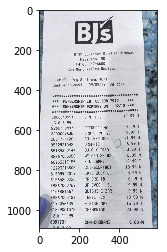

In [45]:
random_path = X_train[np.random.randint(len(X_train))]
img = cv2.imread(random_path)
plt.imshow(img)
plt.show()

/home/user/Mozgalo/inputs/mozgalo/train/BJs/59e5ecb040307c4c69c6101a.jpg


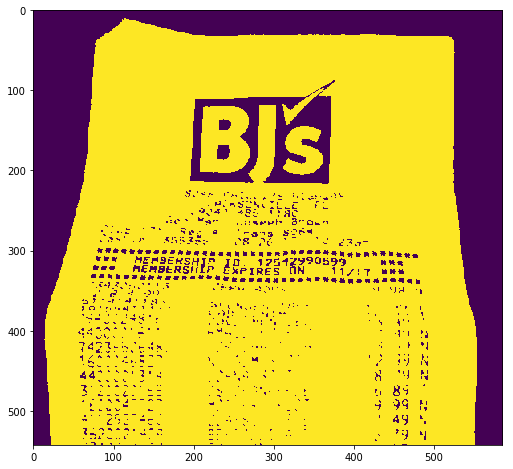

STEP 1: Edge Detection


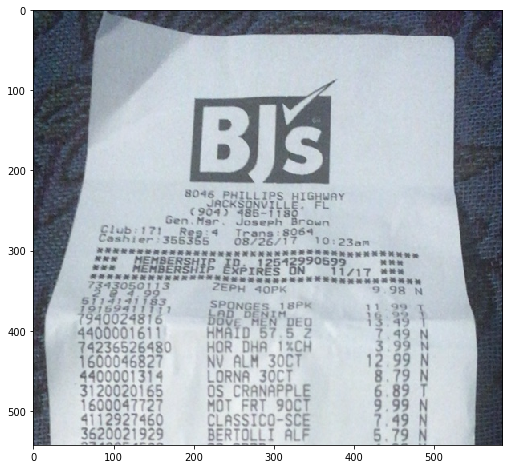

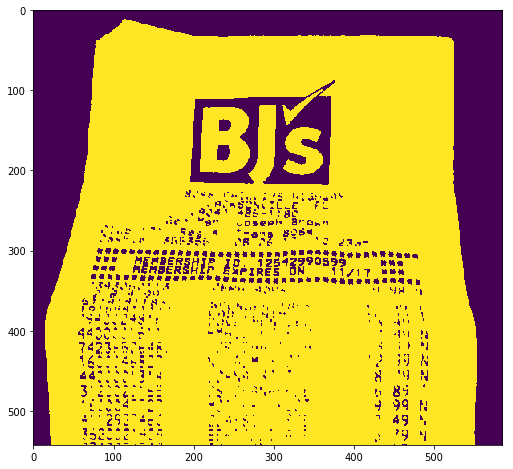

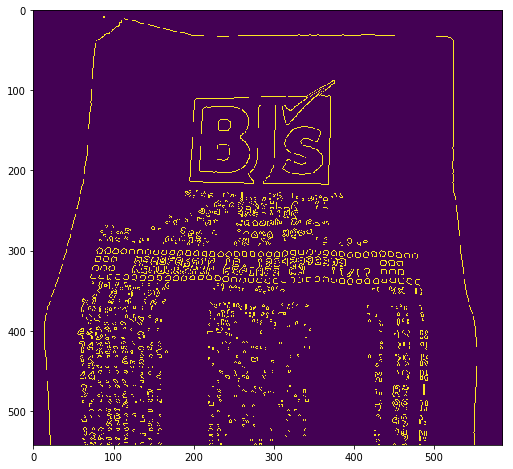

In [62]:
from skimage.filters import threshold_local
import numpy as np
import argparse
import cv2
import imutils

def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped
# load the image and compute the ratio of the old height
# to the new height, clone it, and resize it
random_path = X_train[np.random.randint(len(X_train))]
print(random_path)
image = cv2.imread(random_path)
image = image[:image.shape[0]//2]
# convert the image to grayscale, blur it, and find edges
# in the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# gray = cv2.GaussianBlur(gray, (5, 5), 0)
ret3,gray = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.figure(figsize=(12,8))
plt.imshow(gray)
plt.show()
gray = cv2.erode(gray, (17,17), 15)
edged = cv2.Canny(gray, 0, 200)
 
# show the original image and the edge detected image
print("STEP 1: Edge Detection")
plt.figure(figsize=(12,8))
plt.imshow(image)
plt.show()
plt.figure(figsize=(12,8))
plt.imshow(gray)
plt.show()
plt.figure(figsize=(12,8))
plt.imshow(edged)
plt.show()


In [3]:
import os

results_path = '../outputs/results_for_ansambling/'
results_path = os.path.abspath(results_path)

merged_results = []

for file_name in os.listdir(results_path):
    full_path = os.path.join(results_path, file_name)
    with open(full_path, 'r') as f:
        for i, line in enumerate(f):
            class_name, prob = line.strip().split(',')
            prob = float(prob)
            if len(final_results) > i:
                merged_results[i].append((class_name, prob))
            else:
                merged_results.append([(class_name, prob)])

In [6]:
cnt = 0

for res in final_results:
    res1, res2 = res
    if res1[0] != res2[0]:
        cnt += 1
        
cnt

4375